# Iteration 6

Augemntation, more samples, weighted loss

In [16]:
data_dir = "../../Merge Set Ordered"
iteration = "iteration_6"
model_dir = f'../../models/best_model_{iteration}.h5'

In [20]:
from keras.applications.mobilenet_v3 import preprocess_input


# Now import HomemadeDataloader from homemade_dataloader.py
from homemade_dataloader import DataloaderFactory


batch_size=32
dist = [4000,4000,4000,4000,4000,4000,4000]
print(sum(dist))
histories = []

factory = DataloaderFactory(data_dir, batch_size=batch_size, image_size=(224,224), set_distribution=(70,15,15), class_distribution=dist, preprocess_function=preprocess_input)

train_generator, validation_generator, test_generator = factory.get_dataloaders()

28000
Found 8202 images belonging to 7 classes (dist says 28000)
Found 1758 images belonging to 7 classes (dist says 0)
Found 1758 images belonging to 7 classes (dist says 0)


In [21]:
import sys
import os
sys.path.append(os.path.abspath("../.."))
from custom_model import CustomModel

model = CustomModel(number_of_samples=train_generator.samples)
model.compile()

In [22]:
history1 = model.fit_epochs(train_generator, validation_generator, epochs=5, checkpoint_path=model_dir)
histories.append(history1)

Epoch 1/5
875/875 [==============================] - ETA: 0s - loss: 1.6183 - accuracy: 0.4474
Epoch 1: val_loss improved from inf to 1.29792, saving model to ../../models/best_model_iteration_5_6.h5
875/875 [==============================] - 264s 300ms/step - loss: 1.6183 - accuracy: 0.4474 - val_loss: 1.2979 - val_accuracy: 0.5394
Epoch 2/5


/Users/sebastiangodske/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


875/875 [==============================] - ETA: 0s - loss: 1.1092 - accuracy: 0.6030
Epoch 2: val_loss did not improve from 1.29792
875/875 [==============================] - 260s 297ms/step - loss: 1.1092 - accuracy: 0.6030 - val_loss: 1.3322 - val_accuracy: 0.5503
Epoch 3/5
875/875 [==============================] - ETA: 0s - loss: 0.9504 - accuracy: 0.6629
Epoch 3: val_loss improved from 1.29792 to 1.13481, saving model to ../../models/best_model_iteration_5_6.h5
875/875 [==============================] - 249s 285ms/step - loss: 0.9504 - accuracy: 0.6629 - val_loss: 1.1348 - val_accuracy: 0.6157
Epoch 4/5
875/875 [==============================] - ETA: 0s - loss: 0.8660 - accuracy: 0.6906
Epoch 4: val_loss improved from 1.13481 to 0.94614, saving model to ../../models/best_model_iteration_5_6.h5
875/875 [==============================] - 258s 294ms/step - loss: 0.8660 - accuracy: 0.6906 - val_loss: 0.9461 - val_accuracy: 0.6615
Epoch 5/5
875/875 [==============================] - ET

All layers have been unfrozen.
Epoch 1/10
875/875 [==============================] - 409s 465ms/step - loss: 1.5279 - accuracy: 0.5686 - val_loss: 1.0805 - val_accuracy: 0.7025
Epoch 2/10
875/875 [==============================] - 358s 409ms/step - loss: 0.9499 - accuracy: 0.6926 - val_loss: 0.9987 - val_accuracy: 0.6910
Epoch 3/10
875/875 [==============================] - 346s 395ms/step - loss: 0.7356 - accuracy: 0.7515 - val_loss: 1.0735 - val_accuracy: 0.6725
Epoch 4/10
875/875 [==============================] - 321s 367ms/step - loss: 0.6002 - accuracy: 0.7907 - val_loss: 1.4148 - val_accuracy: 0.6019
Epoch 5/10
875/875 [==============================] - 427s 488ms/step - loss: 0.5118 - accuracy: 0.8183 - val_loss: 1.3007 - val_accuracy: 0.6424
Epoch 6/10
875/875 [==============================] - 354s 405ms/step - loss: 0.4457 - accuracy: 0.8410 - val_loss: 1.2117 - val_accuracy: 0.6661
Epoch 7/10
875/875 [==============================] - 356s 407ms/step - loss: 0.4027 - accura

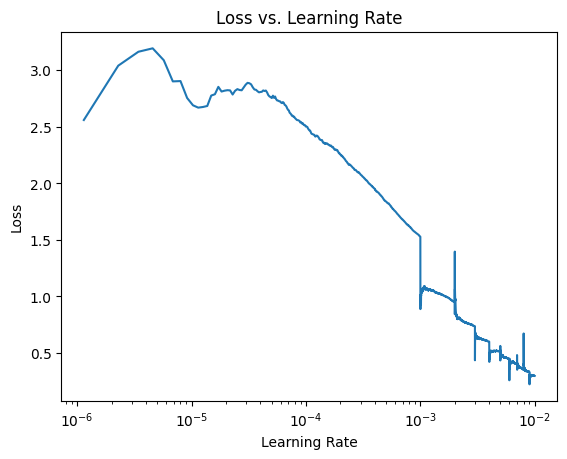

In [23]:
model.unfreeze()
model.lr_find(train_generator, validation_generator)

In [24]:
history2 = model.fit_epochs(train_generator, validation_generator, epochs=40, checkpoint_path=model_dir, lr=[1e-4, 2e-3])
histories.append(history2)

Epoch 1/40
875/875 [==============================] - ETA: 0s - loss: 0.2619 - accuracy: 0.9044
Epoch 1: val_loss improved from inf to 1.11498, saving model to ../../models/best_model_iteration_5_6.h5
875/875 [==============================] - 386s 440ms/step - loss: 0.2619 - accuracy: 0.9044 - val_loss: 1.1150 - val_accuracy: 0.7118
Epoch 2/40
875/875 [==============================] - ETA: 0s - loss: 0.2446 - accuracy: 0.9108
Epoch 2: val_loss improved from 1.11498 to 1.03871, saving model to ../../models/best_model_iteration_5_6.h5
875/875 [==============================] - 350s 400ms/step - loss: 0.2446 - accuracy: 0.9108 - val_loss: 1.0387 - val_accuracy: 0.7245
Epoch 3/40
875/875 [==============================] - ETA: 0s - loss: 0.2336 - accuracy: 0.9167
Epoch 3: val_loss improved from 1.03871 to 1.00060, saving model to ../../models/best_model_iteration_5_6.h5
875/875 [==============================] - 381s 436ms/step - loss: 0.2336 - accuracy: 0.9167 - val_loss: 1.0006 - val_a

['class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6']
Balanced Accuracy: 0.6188451389854579
Accuracy on test set: 0.7829861044883728
F1 Score: 0.7837718490698298


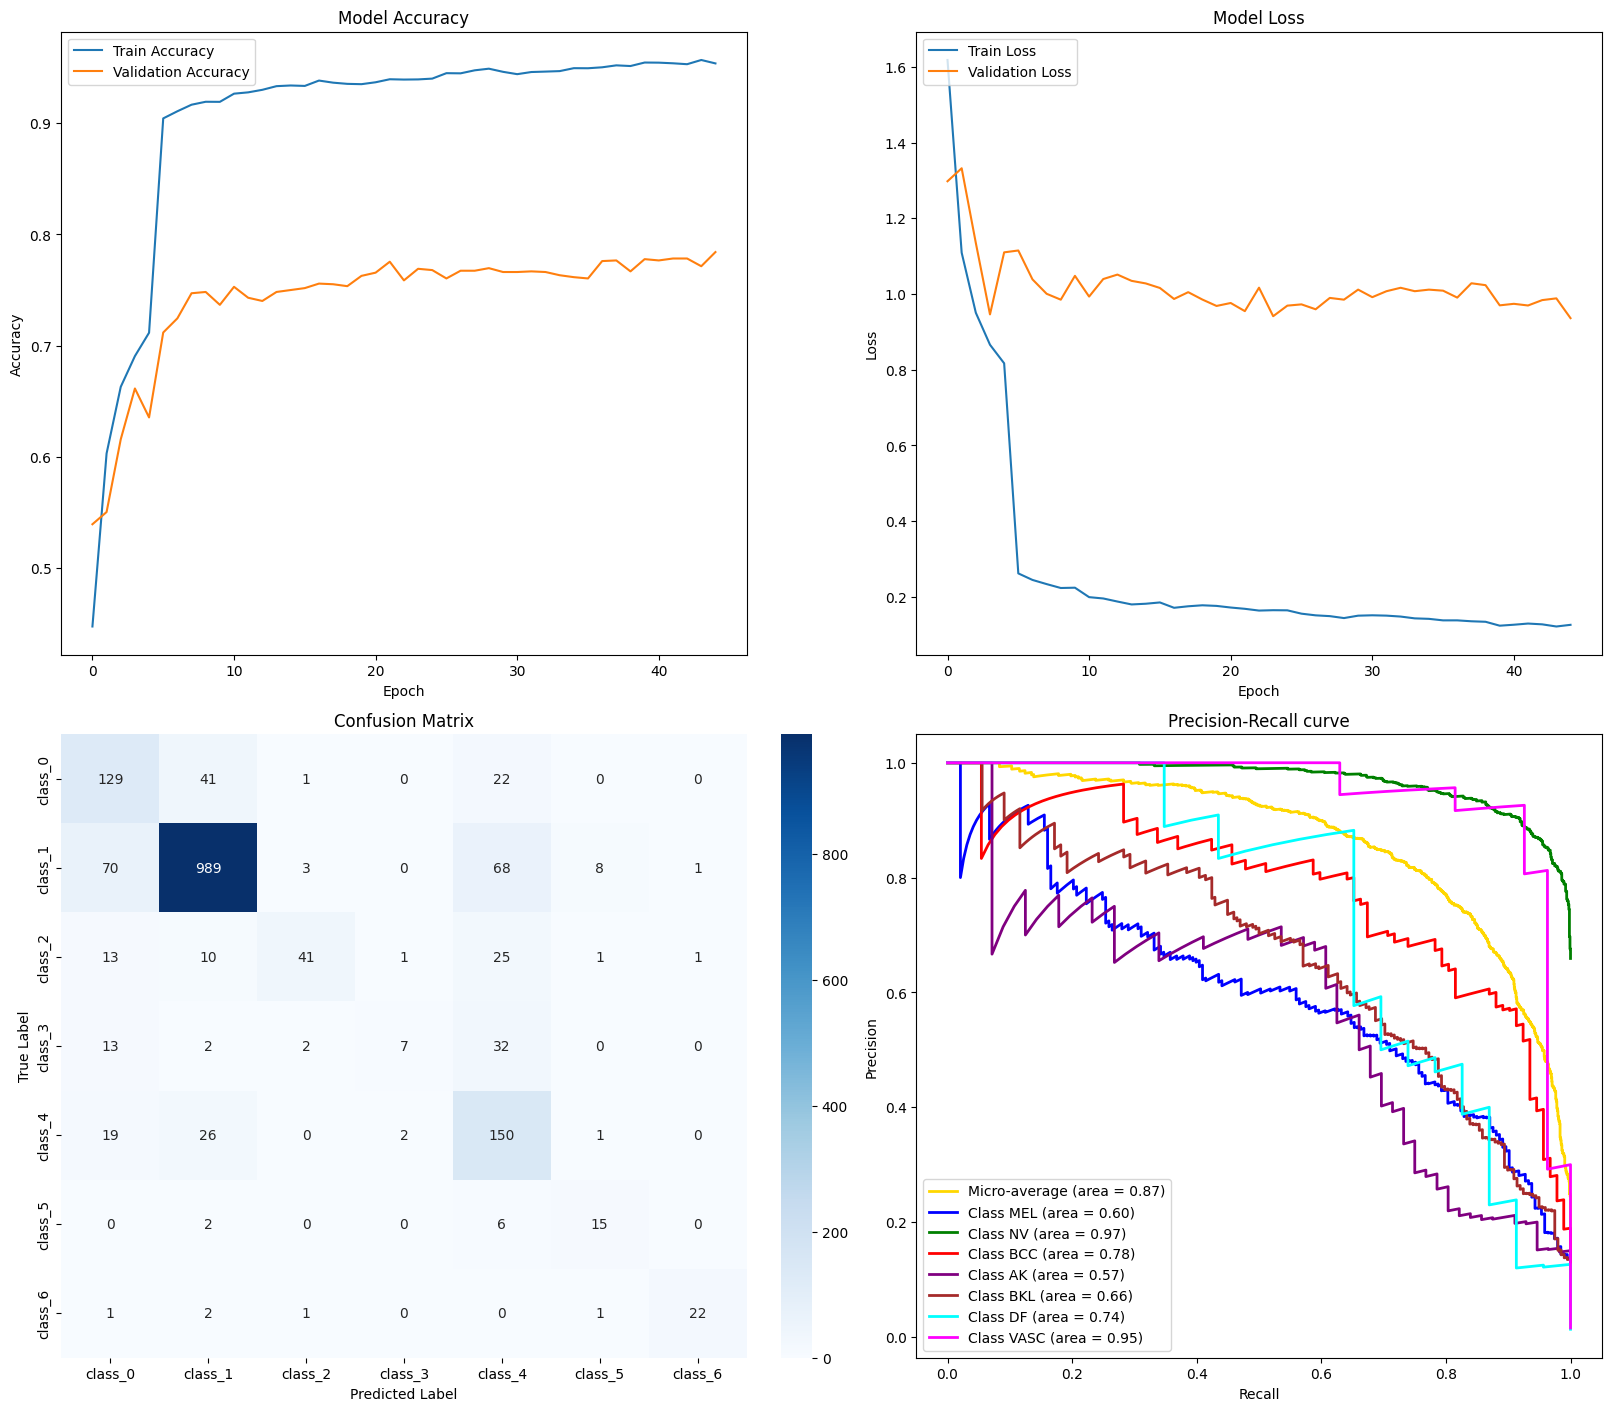

In [25]:
from tensorflow.keras.models import load_model

m = load_model(model_dir)
show_all_plots(histories, m, test_generator)

In [ ]:
model.model.save('my_model.h5')

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Test (Doesnt Matter sorry)

## Iteration 6.1

Reduce LR on Plateau

In [1]:
data_dir = "../../Merge Set Ordered"
iteration = "iteration_6_1"
model_dir = f'../../models/best_model_{iteration}.h5'

In [2]:
from keras.applications.mobilenet_v3 import preprocess_input


# Now import HomemadeDataloader from homemade_dataloader.py
from homemade_dataloader import DataloaderFactory


batch_size=32
dist = [1171,1171,1171,1171,1171,1171,1171]
print(sum(dist))
histories = []

factory = DataloaderFactory(data_dir, batch_size=batch_size, image_size=(224,224), set_distribution=(70,15,15), class_distribution=dist, preprocess_function=preprocess_input)

train_generator, validation_generator, test_generator = factory.get_dataloaders()

/Users/sebastiangodske/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


8197
Found 8202 images belonging to 7 classes (dist says 8197)
Found 1758 images belonging to 7 classes (dist says 0)
Found 1758 images belonging to 7 classes (dist says 0)


In [3]:
import sys
import os
sys.path.append(os.path.abspath("../.."))
from custom_model_iteration_6 import CustomModel

model = CustomModel(number_of_samples=train_generator.samples)
model.compile(optimizer="SGD")

In [4]:
history1 = model.fit_epochs(train_generator, validation_generator, epochs=20, checkpoint_path=model_dir)
histories.append(history1)

Epoch 1/20
256/256 [==============================] - ETA: 0s - loss: 4.0662 - accuracy: 0.5154
Epoch 1: val_loss improved from inf to 3.71534, saving model to ../../models/best_model_iteration_6_1.h5
256/256 [==============================] - 73s 281ms/step - loss: 4.0662 - accuracy: 0.5154 - val_loss: 3.7153 - val_accuracy: 0.6134 - lr: 0.0010
Epoch 2/20


/Users/sebastiangodske/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


256/256 [==============================] - ETA: 0s - loss: 4.0390 - accuracy: 0.6034
Epoch 2: val_loss did not improve from 3.71534
256/256 [==============================] - 72s 280ms/step - loss: 4.0390 - accuracy: 0.6034 - val_loss: 3.8706 - val_accuracy: 0.6128 - lr: 0.0010
Epoch 3/20
256/256 [==============================] - ETA: 0s - loss: 3.8897 - accuracy: 0.6292
Epoch 3: val_loss improved from 3.71534 to 2.90673, saving model to ../../models/best_model_iteration_6_1.h5
256/256 [==============================] - 70s 274ms/step - loss: 3.8897 - accuracy: 0.6292 - val_loss: 2.9067 - val_accuracy: 0.7182 - lr: 0.0010
Epoch 4/20
256/256 [==============================] - ETA: 0s - loss: 3.6101 - accuracy: 0.6470
Epoch 4: val_loss did not improve from 2.90673
256/256 [==============================] - 71s 275ms/step - loss: 3.6101 - accuracy: 0.6470 - val_loss: 5.7393 - val_accuracy: 0.4942 - lr: 0.0010
Epoch 5/20
256/256 [==============================] - ETA: 0s - loss: 3.4565 - 

In [5]:
history2 = model.fit_epochs(train_generator, validation_generator, epochs=20, checkpoint_path=model_dir)
histories.append(history2)

Epoch 1/20
256/256 [==============================] - ETA: 0s - loss: 1.3177 - accuracy: 0.7836
Epoch 1: val_loss improved from inf to 2.66082, saving model to ../../models/best_model_iteration_6_1.h5
256/256 [==============================] - 74s 287ms/step - loss: 1.3177 - accuracy: 0.7836 - val_loss: 2.6608 - val_accuracy: 0.6447 - lr: 2.5000e-04
Epoch 2/20


/Users/sebastiangodske/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


256/256 [==============================] - ETA: 0s - loss: 1.2660 - accuracy: 0.7848
Epoch 2: val_loss improved from 2.66082 to 1.86992, saving model to ../../models/best_model_iteration_6_1.h5
256/256 [==============================] - 72s 282ms/step - loss: 1.2660 - accuracy: 0.7848 - val_loss: 1.8699 - val_accuracy: 0.7199 - lr: 2.5000e-04
Epoch 3/20
256/256 [==============================] - ETA: 0s - loss: 1.3272 - accuracy: 0.7780
Epoch 3: val_loss did not improve from 1.86992
256/256 [==============================] - 75s 293ms/step - loss: 1.3272 - accuracy: 0.7780 - val_loss: 2.0336 - val_accuracy: 0.6904 - lr: 2.5000e-04
Epoch 4/20
256/256 [==============================] - ETA: 0s - loss: 1.1754 - accuracy: 0.7876
Epoch 4: val_loss did not improve from 1.86992
256/256 [==============================] - 73s 284ms/step - loss: 1.1754 - accuracy: 0.7876 - val_loss: 2.0324 - val_accuracy: 0.6863 - lr: 2.5000e-04
Epoch 5/20
256/256 [==============================] - ETA: 0s - los

In [6]:
model.unfreeze()
history2 = model.fit_epochs(train_generator, validation_generator, epochs=50, checkpoint_path=model_dir)
histories.append(history2)

All layers have been unfrozen.
Epoch 1/50
256/256 [==============================] - ETA: 0s - loss: 0.8381 - accuracy: 0.8171
Epoch 1: val_loss improved from inf to 1.86371, saving model to ../../models/best_model_iteration_6_1.h5
256/256 [==============================] - 75s 291ms/step - loss: 0.8381 - accuracy: 0.8171 - val_loss: 1.8637 - val_accuracy: 0.6748 - lr: 3.1250e-05
Epoch 2/50
256/256 [==============================] - ETA: 0s - loss: 0.7894 - accuracy: 0.8223
Epoch 2: val_loss improved from 1.86371 to 1.81564, saving model to ../../models/best_model_iteration_6_1.h5
256/256 [==============================] - 72s 280ms/step - loss: 0.7894 - accuracy: 0.8223 - val_loss: 1.8156 - val_accuracy: 0.6852 - lr: 3.1250e-05
Epoch 3/50
256/256 [==============================] - ETA: 0s - loss: 0.8254 - accuracy: 0.8112
Epoch 3: val_loss did not improve from 1.81564
256/256 [==============================] - 72s 280ms/step - loss: 0.8254 - accuracy: 0.8112 - val_loss: 1.8228 - val_a

['class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6']
Balanced Accuracy: 0.6307120786120671
Accuracy on test set: 0.7025462985038757
F1 Score: 0.7250531559525449


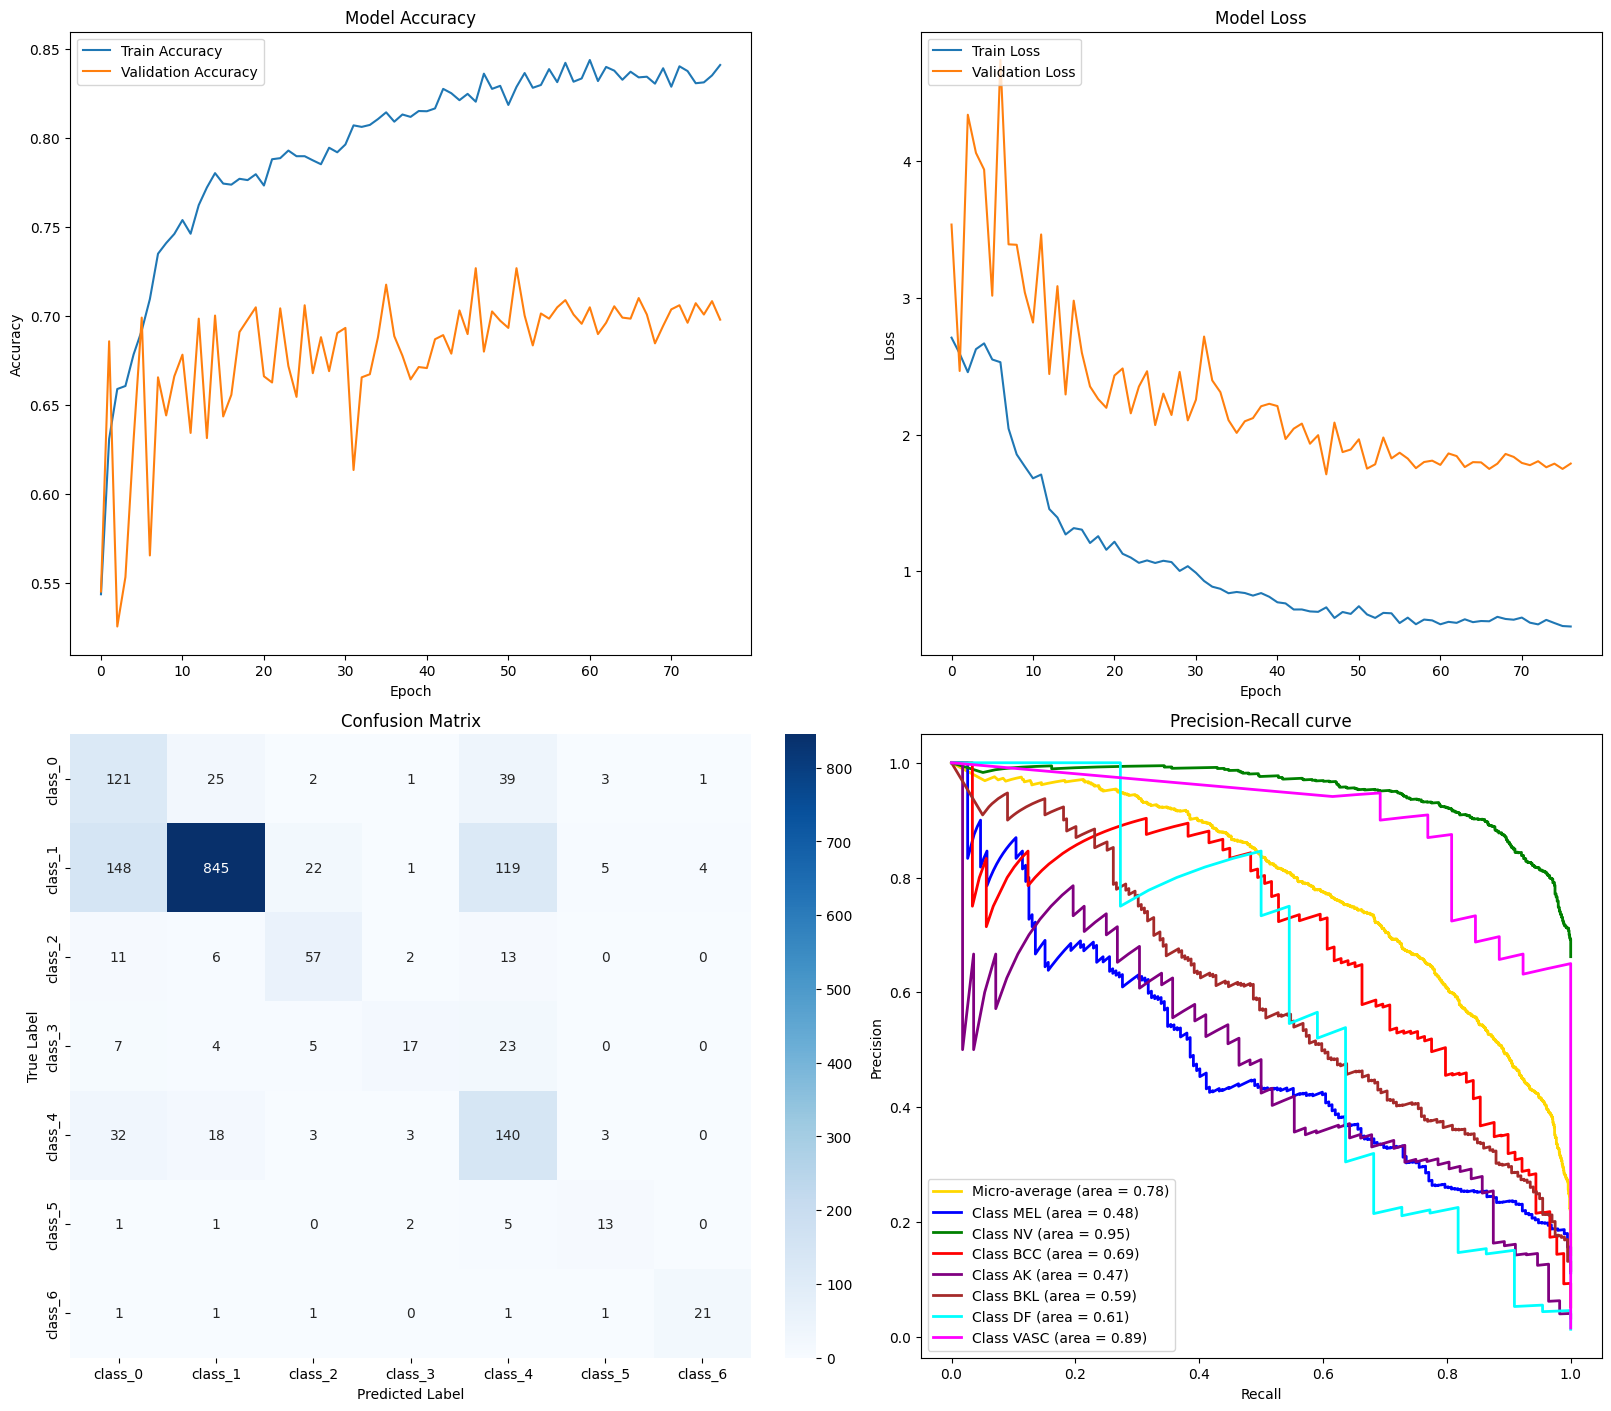

In [15]:
from tensorflow.keras.models import load_model
from plot_utils import show_all_plots

m = load_model(model_dir)
show_all_plots(histories, m, test_generator)

## Iteration 6.2

Adam

In [8]:
data_dir = "../../Merge Set Ordered"
iteration = "iteration_6_2"
model_dir = f'../../models/best_model_{iteration}.h5'

In [9]:
from keras.applications.mobilenet_v3 import preprocess_input


# Now import HomemadeDataloader from homemade_dataloader.py
from homemade_dataloader import DataloaderFactory


batch_size=32
dist = [1171,1171,1171,1171,1171,1171,1171]
print(sum(dist))
histories = []

factory = DataloaderFactory(data_dir, batch_size=batch_size, image_size=(224,224), set_distribution=(70,15,15), class_distribution=dist, preprocess_function=preprocess_input)

train_generator, validation_generator, test_generator = factory.get_dataloaders() 

8197
Found 8202 images belonging to 7 classes (dist says 8197)
Found 1758 images belonging to 7 classes (dist says 0)
Found 1758 images belonging to 7 classes (dist says 0)


In [10]:
import sys
import os
sys.path.append(os.path.abspath("../.."))
from custom_model_iteration_6 import CustomModel

model = CustomModel(number_of_samples=train_generator.samples)
model.compile(optimizer="ADAM")

In [11]:
history1 = model.fit_epochs(train_generator, validation_generator, epochs=20, checkpoint_path=model_dir)
histories.append(history1)

Epoch 1/20
256/256 [==============================] - ETA: 0s - loss: 2.7082 - accuracy: 0.5436
Epoch 1: val_loss improved from inf to 3.53489, saving model to ../../models/best_model_iteration_6_2.h5
256/256 [==============================] - 73s 280ms/step - loss: 2.7082 - accuracy: 0.5436 - val_loss: 3.5349 - val_accuracy: 0.5451 - lr: 0.0010
Epoch 2/20


/Users/sebastiangodske/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


256/256 [==============================] - ETA: 0s - loss: 2.5914 - accuracy: 0.6309
Epoch 2: val_loss improved from 3.53489 to 2.46446, saving model to ../../models/best_model_iteration_6_2.h5
256/256 [==============================] - 69s 271ms/step - loss: 2.5914 - accuracy: 0.6309 - val_loss: 2.4645 - val_accuracy: 0.6858 - lr: 0.0010
Epoch 3/20
256/256 [==============================] - ETA: 0s - loss: 2.4556 - accuracy: 0.6589
Epoch 3: val_loss did not improve from 2.46446
256/256 [==============================] - 69s 269ms/step - loss: 2.4556 - accuracy: 0.6589 - val_loss: 4.3378 - val_accuracy: 0.5255 - lr: 0.0010
Epoch 4/20
256/256 [==============================] - ETA: 0s - loss: 2.6240 - accuracy: 0.6606
Epoch 4: val_loss did not improve from 2.46446
256/256 [==============================] - 69s 270ms/step - loss: 2.6240 - accuracy: 0.6606 - val_loss: 4.0590 - val_accuracy: 0.5532 - lr: 0.0010
Epoch 5/20
256/256 [==============================] - ETA: 0s - loss: 2.6662 - 

In [12]:
model.unfreeze()
history2 = model.fit_epochs(train_generator, validation_generator, epochs=50, checkpoint_path=model_dir)
histories.append(history2)

All layers have been unfrozen.
Epoch 1/50
256/256 [==============================] - ETA: 0s - loss: 1.2161 - accuracy: 0.7733
Epoch 1: val_loss improved from inf to 2.43154, saving model to ../../models/best_model_iteration_6_2.h5
256/256 [==============================] - 70s 273ms/step - loss: 1.2161 - accuracy: 0.7733 - val_loss: 2.4315 - val_accuracy: 0.6661 - lr: 2.5000e-04
Epoch 2/50
256/256 [==============================] - ETA: 0s - loss: 1.1280 - accuracy: 0.7881
Epoch 2: val_loss did not improve from 2.43154
256/256 [==============================] - 69s 269ms/step - loss: 1.1280 - accuracy: 0.7881 - val_loss: 2.4828 - val_accuracy: 0.6626 - lr: 2.5000e-04
Epoch 3/50
256/256 [==============================] - ETA: 0s - loss: 1.1004 - accuracy: 0.7887
Epoch 3: val_loss improved from 2.43154 to 2.15475, saving model to ../../models/best_model_iteration_6_2.h5
256/256 [==============================] - 70s 274ms/step - loss: 1.1004 - accuracy: 0.7887 - val_loss: 2.1547 - val_a

In [14]:
history3 = model.fit_epochs(train_generator, validation_generator, epochs=50, checkpoint_path=model_dir)
histories.append(history3)

Epoch 1/50
256/256 [==============================] - ETA: 0s - loss: 0.6129 - accuracy: 0.8423
Epoch 1: val_loss improved from inf to 1.75422, saving model to ../../models/best_model_iteration_6_2.h5
256/256 [==============================] - 73s 284ms/step - loss: 0.6129 - accuracy: 0.8423 - val_loss: 1.7542 - val_accuracy: 0.7089 - lr: 1.5625e-05
Epoch 2/50


/Users/sebastiangodske/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


256/256 [==============================] - ETA: 0s - loss: 0.6471 - accuracy: 0.8317
Epoch 2: val_loss did not improve from 1.75422
256/256 [==============================] - 71s 278ms/step - loss: 0.6471 - accuracy: 0.8317 - val_loss: 1.7989 - val_accuracy: 0.7008 - lr: 1.5625e-05
Epoch 3/50
256/256 [==============================] - ETA: 0s - loss: 0.6410 - accuracy: 0.8335
Epoch 3: val_loss did not improve from 1.75422
256/256 [==============================] - 71s 276ms/step - loss: 0.6410 - accuracy: 0.8335 - val_loss: 1.8088 - val_accuracy: 0.6956 - lr: 1.5625e-05
Epoch 4/50
256/256 [==============================] - ETA: 0s - loss: 0.6126 - accuracy: 0.8439
Epoch 4: val_loss did not improve from 1.75422
256/256 [==============================] - 72s 281ms/step - loss: 0.6126 - accuracy: 0.8439 - val_loss: 1.7780 - val_accuracy: 0.7049 - lr: 1.5625e-05
Epoch 5/50
256/256 [==============================] - ETA: 0s - loss: 0.6304 - accuracy: 0.8320
Epoch 5: val_loss did not improve

['class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6']
Balanced Accuracy: 0.6482571731603558
Accuracy on test set: 0.7233796119689941
F1 Score: 0.742805373424869


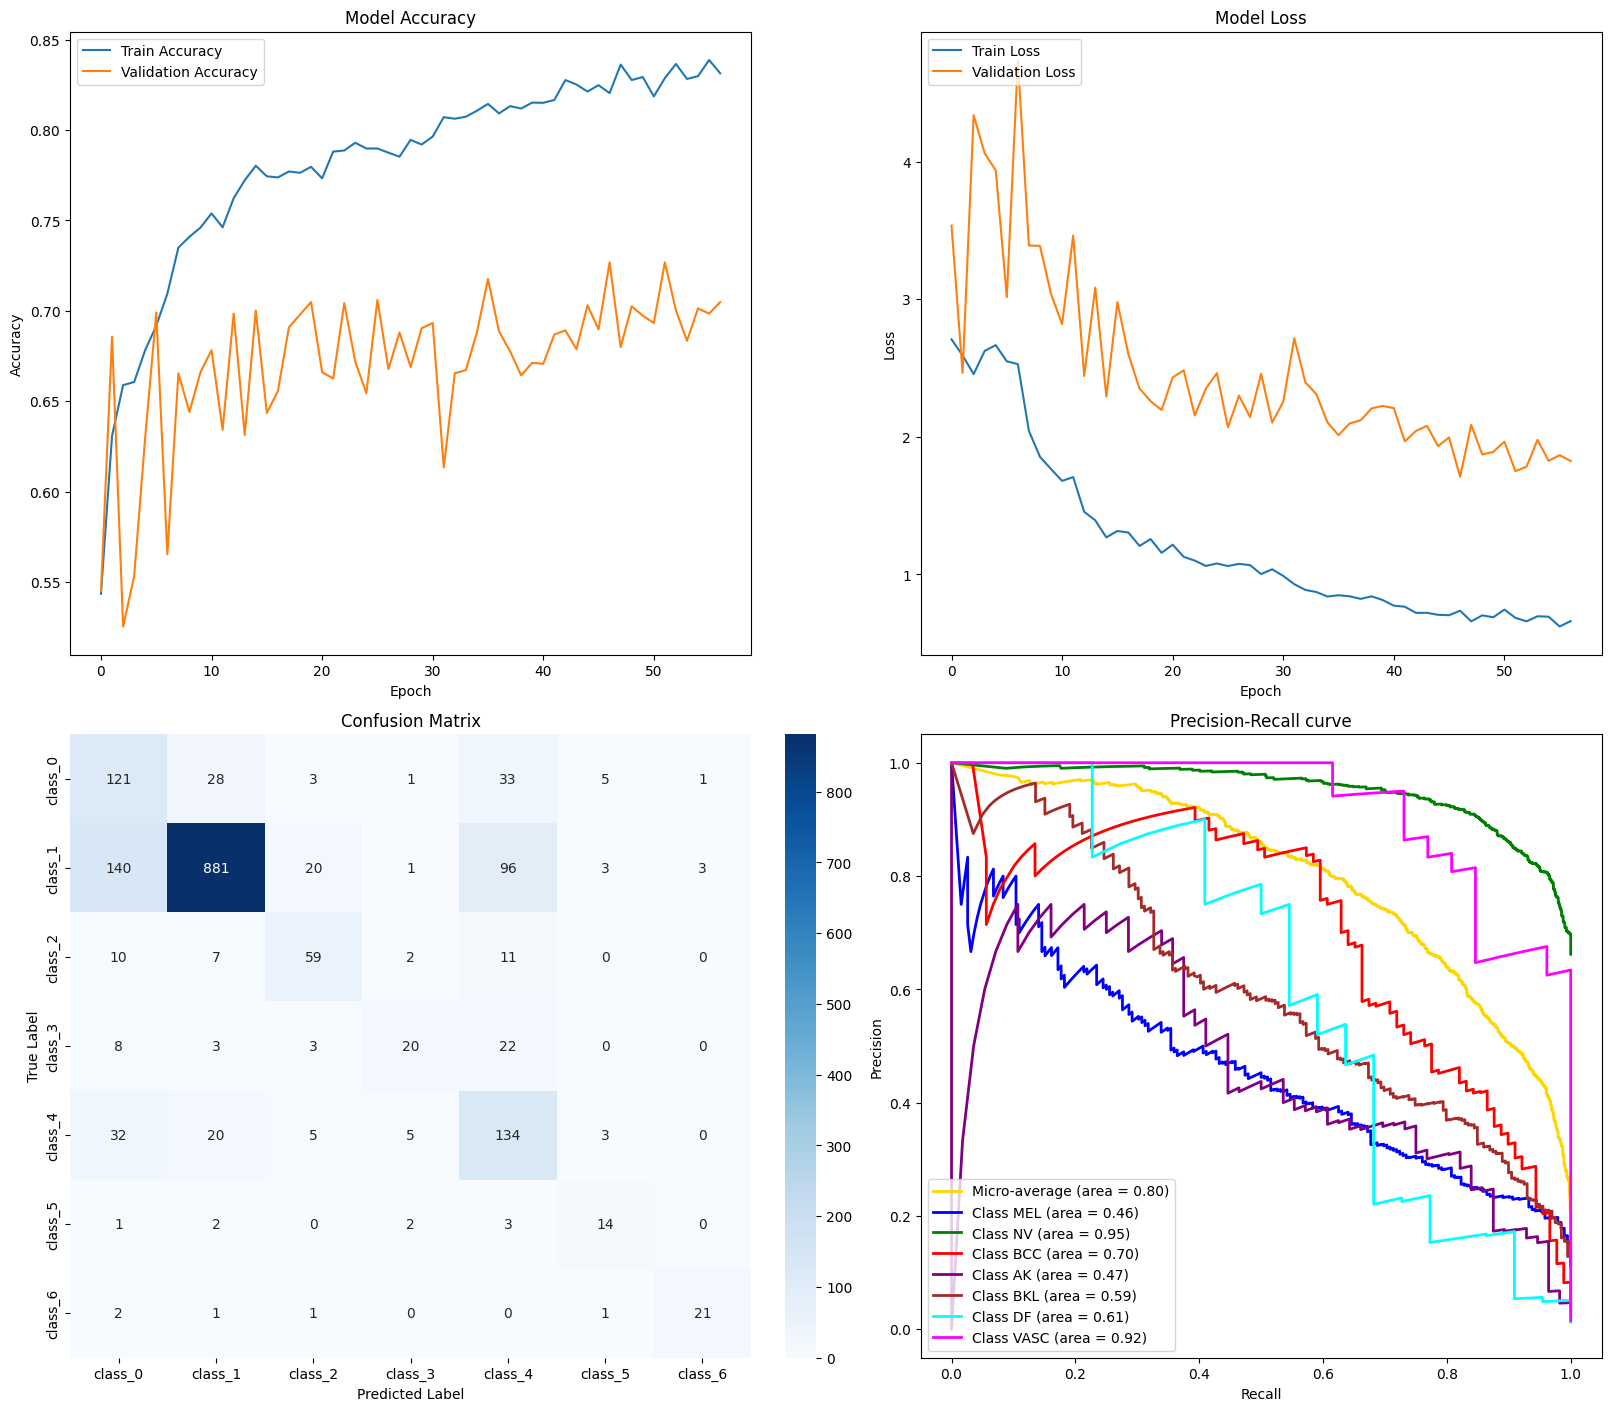

In [13]:
from tensorflow.keras.models import load_model

m = load_model(model_dir)
show_all_plots(histories, m, test_generator)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, precision_recall_curve, average_precision_score, f1_score
from sklearn.preprocessing import label_binarize

class CombinedHistory:
    def __init__(self, combined_history_dict):
        self.history = combined_history_dict

def combine_histories(histories):
    combined_history = {}
    for key in histories[0].history.keys():
        combined_history[key] = []
        for history in histories:
            combined_history[key].extend(history.history[key])
    return CombinedHistory(combined_history)

# Define the function to plot all metrics including balanced accuracy
def show_all_plots(histories, model, validation_generator):


    if isinstance(histories, list):  # Check if it's a list of histories
        history = combine_histories(histories)
    else:  # If single history is passed, use it directly
        history = histories.history
    


    # Assuming `validation_generator` has class indices mapped to class names
    class_names = list(validation_generator.class_names)
    print(class_names)

    # Calculate balanced accuracy for each epoch

    # Get true labels and predictions for the entire validation set
    y_true = []
    y_pred = []

    for i in range(len(validation_generator)):
        X_val_batch, y_val_batch = validation_generator[i]
        y_pred_batch = model.predict(X_val_batch, verbose=0)
        y_pred.extend(y_pred_batch)  # Keep the raw probabilities for precision-recall
        y_true.extend(y_val_batch)   # Keep the one-hot encoded true labels

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate balanced accuracy, confusion matrix, and F1 score
    y_true_labels = np.argmax(y_true, axis=1)
    y_pred_labels = np.argmax(y_pred, axis=1)
    balanced_acc = balanced_accuracy_score(y_true_labels, y_pred_labels)
    conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

    # Print metrics
    print(f"Balanced Accuracy: {balanced_acc}")
    print(f"Accuracy on test set: {model.evaluate(validation_generator, verbose=0)[1]}")
    print(f"F1 Score: {f1_score(y_true_labels, y_pred_labels, average='weighted')}")

    # Set up a 2x2 grid for the plots
    plt.figure(figsize=(16,14), constrained_layout=True)
    
    # 1. Accuracy plot
    plt.subplot(2, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    # 2. Loss plot
    plt.subplot(2, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    # 3. Confusion matrix plot
    plt.subplot(2, 2, 3)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    # 4. Precision-Recall Curve plot
    plt.subplot(2, 2, 4)
    show_precision_recall(y_true, y_pred)

    # Show all the plots
    plt.show()

def show_precision_recall(y_test, predictions):
    class_names = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC']
    
    # Binarize the output for multiclass
    y_test = label_binarize(y_test, classes=range(len(class_names)))
    predictions = np.array(predictions)

    precision = dict()
    recall = dict()
    average_precision = dict()
    
    # Compute Precision-Recall and average precision for each class
    for i in range(len(class_names)):
        precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], predictions[:, i])
        average_precision[i] = average_precision_score(y_test[:, i], predictions[:, i])

    # Compute micro-average Precision-Recall curve and area
    precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(), predictions.ravel())
    average_precision["micro"] = average_precision_score(y_test, predictions, average="micro")
    
    # Plot Precision-Recall curve
    plt.plot(recall["micro"], precision["micro"], color='gold', lw=2, label=f'Micro-average (area = {average_precision["micro"]:0.2f})')
    for i, color in enumerate(['blue', 'green', 'red', 'purple', 'brown', 'cyan', 'magenta']):
        plt.plot(recall[i], precision[i], color=color, lw=2, label=f'Class {class_names[i]} (area = {average_precision[i]:0.2f})')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')
    plt.legend(loc='best')
